## Extract the path of particle tracking outputs
### Following code read the outputs of particle tracking and extracts the latitude and longitude 

### Required Imports

In [168]:
# Importing libraries
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib import rcParams
import re 

In [ ]:
#define a path to the FVCOME data directory /home/samin/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA
# go forlder 202301 and red nc file contain *2230101.nc
# define the path to the data directory
data_dir = '/home/samin/data/FVCOME_OUTPUT/simulations/Huron/output'

In [177]:
# Custom sorting function
def sort_key(file):
    # Extract the filename from the file path
    filename = os.path.basename(file)
    # Extract the number from the filename
    number = int(filename.split('__')[1].split('.')[0])
    return number

# Get the files and sort them
files = glob.glob(os.path.join(data_dir, 'Fvcome_houron_estuary_*.nc'))
files.sort(key=sort_key)

# Read all the nc files into a list of xarray datasets and sort them by time
datasets = [xr.open_dataset(file) for file in files]

In [144]:
#datasets[0]
# Extract the time variable from the datasets
times = [dataset.time.values for dataset in datasets]


<xarray.Dataset>
Dimensions:                   (time: 49, particles: 234)
Coordinates:
  * time                      (time) datetime64[ns] 2023-01-01T01:00:00 ... 2...
Dimensions without coordinates: particles
Data variables:
    group_id                  (particles) int32 ...
    longitude                 (time, particles) float32 ...
    latitude                  (time, particles) float32 ...
    depth                     (time, particles) float32 ...
    host_fvcom                (time, particles) int32 ...
    error_status              (time, particles) int32 ...
    in_domain                 (time, particles) int32 ...
    is_beached                (time, particles) int32 ...
    land_boundary_encounters  (time, particles) int32 ...
    thetao                    (time, particles) float32 ...
    so                        (time, particles) float32 ...
Attributes:
    title:    PyLag -- Plymouth Marine Laboratory

In [181]:
datasets[1999].time.values

array(['2023-03-25T08:00:00.000000000', '2023-03-25T08:15:00.000000000',
       '2023-03-25T08:30:00.000000000', '2023-03-25T08:45:00.000000000',
       '2023-03-25T09:00:00.000000000', '2023-03-25T09:15:00.000000000',
       '2023-03-25T09:30:00.000000000', '2023-03-25T09:45:00.000000000',
       '2023-03-25T10:00:00.000000000', '2023-03-25T10:15:00.000000000',
       '2023-03-25T10:30:00.000000000', '2023-03-25T10:45:00.000000000',
       '2023-03-25T11:00:00.000000000', '2023-03-25T11:15:00.000000000',
       '2023-03-25T11:30:00.000000000', '2023-03-25T11:45:00.000000000',
       '2023-03-25T12:00:00.000000000', '2023-03-25T12:15:00.000000000',
       '2023-03-25T12:30:00.000000000', '2023-03-25T12:45:00.000000000',
       '2023-03-25T13:00:00.000000000', '2023-03-25T13:15:00.000000000',
       '2023-03-25T13:30:00.000000000', '2023-03-25T13:45:00.000000000',
       '2023-03-25T14:00:00.000000000', '2023-03-25T14:15:00.000000000',
       '2023-03-25T14:30:00.000000000', '2023-03-25

In [184]:
# from datetime import datetime

# # Custom sorting function
# def sort_key(file):
#     # Extract the filename from the file path
#     filename = os.path.basename(file)
#     # Extract the date and time from the filename
#     date_time_str = filename.split('_')[3]
#     date_str = date_time_str.split('.')[0]
#     time_str = date_time_str.split('.')[1]
#     # Convert the date and time to a datetime object
#     date_time = datetime.strptime(date_str + time_str, '%Y%m%dt%Hz')
#     return date_time

# # Get the files and sort them
# files = glob.glob(os.path.join(data_dir, 'Fvcome_houron_estuary_*.nc'))
# files.sort(key=sort_key)

# # Read all the nc files into a list of xarray datasets and sort them by time
# drop_variables=['siglay','siglev']
# datasets = [xr.open_dataset(file,decode_times= False, drop_variables=drop_variables) for file in files]


### Read all the lats and longs from the datasets

In [183]:

lats_watershed = [ds.latitude.values for ds in datasets]
lons_watershed = [ds.longitude.values for ds in datasets]
time = [ds.time.values for ds in datasets]
# convert to numpy arrays and flatten
lats_watershed = np.array(lats_watershed)
lons_watershed = np.array(lons_watershed)

# Stack them column-wise
data = np.column_stack((lons_watershed.flatten(), lats_watershed.flatten()))

#save the data to a text file in a data dir directory
# Save the data to a text csv file
#np.savetxt(os.path.join(data_dir, 'lons_lats_watershed.txt'), data, fmt='%f %f', header='longitude,latitudes')

#save the data to a csv file in a data dir directory
# Save the data to a text csv file with a header using pandas
import pandas as pd
df = pd.DataFrame(data, columns=['longitude', 'latitude'])
df.to_csv(os.path.join(data_dir, 'lons_lats_watershed.csv'), index=False)


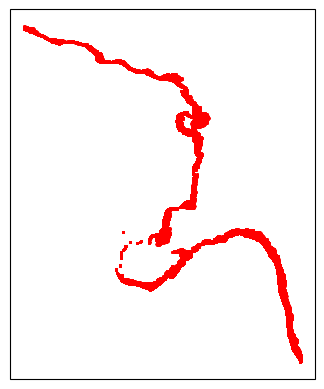

In [185]:
# Plot the data with caropy and cartopy adn add the coastline, lakes, and rivers
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and axis
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# Add the coastline, lakes, and rivers
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.LAKES)

# Plot the data each point with a different color
ax. scatter(lons_watershed, lats_watershed, c='r', s=1)



#### Read the lats and lons for the particle tracking and coastal wetlands point and find the overlap between them 
#### In the following part i will read the particle tracking output that I ran for three months and I find how many particles end up in Coastal Wetlands 

In [190]:
# path to watershed particle tracking data
watershed_data_dir = '/home/samin/data/FVCOME_OUTPUT/simulations/Huron/lons_lats_watershed.csv'
# path to the coastal wetland and lake intersection
Coastal_data = '/home/samin/data/FVCOME_OUTPUT/simulations/Huron/wetland_connected_avg_inundation_Albers_lh_shoreline_intesection_reproject_snap5km.csv'

In [187]:
# Read the watershed data into a pandas dataframe and read latitude and longitude columns
watershed_df = pd.read_csv(watershed_data_dir)
lons_watershed = watershed_df['longitude'].values
lats_watershed = watershed_df['latitude'].values


In [196]:
# print lons and lats column
print(len(lons_watershed))
print(len(lats_watershed))


22932000
22932000


In [191]:
# Read the coastal data into a pandas dataframe and read latitude and longitude columns
coastal_df = pd.read_csv(Coastal_data)
lons_coastal = coastal_df['longitude'].values
lats_coastal = coastal_df['latitude'].values

In [197]:
# print lons and lats column
print(len(lons_coastal))
print(len(lats_coastal))

4103
4103


In [195]:
# for the lon and lat of the watershed data find the nearest points in the coastal data and print those values
from scipy.spatial import cKDTree
# Create a KDTree object
tree = cKDTree(np.column_stack((lons_coastal, lats_coastal)))
# Query the tree for the nearest points
distances, indices = tree.query(np.column_stack((lons_watershed, lats_watershed)))
# Print the indices of the nearest points
print(indices)
# Print the distances to the nearest points
print(distances)
# Print the lons and lats of the nearest points
print(lons_coastal[indices])
print(lats_coastal[indices])
# print how many points are within 1 km of the coastal data



[   0    0    0 ... 1694    0 1694]
[6.31447351e-01 6.23243190e-01 5.65402654e-01 ... 1.54673974e-02
 3.58301937e+02 1.05008162e-02]
[275.8697162 275.8697162 275.8697162 ... 277.5741778 275.8697162
 277.5741778]
[45.56459226 45.56459226 45.56459226 ... 43.01667639 45.56459226
 43.01667639]


In [200]:
# # for the lon and lat of the watershed data find the nearest points in the coastal data and print those values
# show how many point are within 1 km of the coastal data
# Create a KDTree object
tree = cKDTree(np.column_stack((lons_coastal, lats_coastal)))
# Query the tree for the nearest points
distances, indices = tree.query(np.column_stack((lons_watershed, lats_watershed)), k=5)
# Print the indices of the nearest points
print(indices)
# Print the distances to the nearest points
print(distances)
# Print the lons and lats of the nearest points
print(lons_coastal[indices])
print(lats_coastal[indices])
# Print how many points are within 1 km of the coastal data
print(np.sum(distances < 1))



[[   0    1    2    3    4]
 [   0    1    2    3    4]
 [   0    1    2    3    4]
 ...
 [1694 1693 1692 1690 1695]
 [   0    1    2    3    4]
 [1694 1707 1706 1720 4048]]
[[6.31447351e-01 6.38408636e-01 6.50057182e-01 6.54358149e-01
  6.55284107e-01]
 [6.23243190e-01 6.30097767e-01 6.41281494e-01 6.45476616e-01
  6.46381726e-01]
 [5.65402654e-01 5.72240508e-01 5.83407318e-01 5.87611601e-01
  5.88519105e-01]
 ...
 [1.54673974e-02 1.90708707e-02 2.04468500e-02 2.05142380e-02
  2.05551899e-02]
 [3.58301937e+02 3.58306595e+02 3.58308487e+02 3.58310240e+02
  3.58310647e+02]
 [1.05008162e-02 2.87800519e-02 2.87874034e-02 2.89467934e-02
  2.91296758e-02]]
[[275.8697162 275.8744266 275.8765067 275.878307  275.8787241]
 [275.8697162 275.8744266 275.8765067 275.878307  275.8787241]
 [275.8697162 275.8744266 275.8765067 275.878307  275.8787241]
 ...
 [277.5741778 277.5499416 277.5484296 277.5482185 277.5491504]
 [275.8697162 275.8744266 275.8765067 275.878307  275.8787241]
 [277.5741778 277.55

In [202]:
# Print how many points are within 1 km of the coastal data
print(np.sum(distances < 5))


107197835
